In [ ]:
# Notebook to generate new graph object for training testing your customized data
# using iCafe project folder as an example, if your data is not in the iCafe framework, you need to provide equavalent files:
# For testing only: SWC format of centerlines
# For training, needs additional SWC format of labeled centerlines (giving edge labels) and landmark list (giving node labels)
# Li Chen
# 3/7/2021

In [1]:
import os
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt

from matchvestype import matchvestype
from gnn_utils import VESTYPENUM, BOITYPENUM
from iCafePythonBasic import SnakeList, Snake, SWCNode, Point3D

In [2]:
#supporting functions
def loadSWCFile(swcfilename):
    #node info in SWCNode, in and output. Load swclist
    swclist = []
    #snakelist representation, link with swclist
    snakelist = SnakeList()
    if not os.path.exists(swcfilename):
        print('not exist', swcfilename)
        return snakelist, swclist
    with open(swcfilename,'r') as fp:
        for line in fp:
            swclist.append(SWCNode.fromline(line))
    temp_Snake = []
    for i in range(len(swclist)):
        if i > 0 and swclist[i].pid == -1:
            #end last snake
            snakelist.addSnake(Snake(temp_Snake))
            temp_Snake.clear()
            #add new point
            temp_Snake.append(swclist[i])
        else:
            temp_Snake.append(swclist[i])
        #end of the swc file
        if i == len(swclist) - 1:
            snakelist.addSnake(Snake(temp_Snake))
            temp_Snake.clear()
    return snakelist

def loadVes(path):
    if not os.path.exists(path):
        raise FileNotFoundError('No vessel file available',path)
    vessnakelist = SnakeList()
    cveslist = []
    starttype = -1
    endtype = -1

    with open(path,'r') as fp:
        for line in fp:
            cswcnode = SWCNode.fromline(line)
            cveslist.append(cswcnode)
            if cswcnode.type!=0:
                if starttype==-1:
                    starttype = cswcnode.type
                else:
                    endtype = cswcnode.type
                    cvestype = matchvestype(starttype,endtype)
                    starttype=-1
                    endtype=-1
                    if cvestype!=-1:
                        vessnakelist.addSnake(Snake(cveslist,cvestype))
                    else:
                        print('Unknown ves match type',starttype,endtype)
                    cveslist.clear()
    return vessnakelist

# construct graph with only key nodes (deg!=2)
def generateSimG(snakelist, ves_snakelist, landmark, ASSIGNNODE=0, ASSIGNEDGE=0, ASSIGNDIR=0):
    swclist = snakelist.toSWCList()
    if ASSIGNNODE:
        if len(landmark) == 0:
            raise ValueError('landmark is empty')
        landmarkposmap = {}
        for lmtype, lmpos in landmark:
            # ignore M2/3
            if lmtype in [13, 14]:
                continue
            landmarkposmap[lmpos.hashPos()] = lmtype

    if ASSIGNEDGE:
        if len(swclist) == 0:
            raise ValueError('Vessnake empty')
        #veslist [[] for i in range(VESTYPE))]
        veslist = ves_snakelist.toVesList()
        vesposmap = {}
        for ctype in range(1, VESTYPENUM):
            if len(veslist[ctype]) == 0:
                continue
            for snakei in veslist[ctype]:
                # skip start and end point for ves type mapping (might appear in multiple snake)
                for nodeid in range(1, len(snakei) - 1):
                    vesposmap[snakei[nodeid].pos.hashPos()] = ctype

    if ASSIGNDIR:
        availdirs = [Point3D(0, 0, -1), Point3D(0, 0, 1)]
        for ag1 in range(-45, 46, 45):
            for ag2 in range(0, 360, 45):
                xi = np.cos(ag1 / 180 * np.pi) * np.sin(ag2 / 180 * np.pi)
                yi = np.cos(ag1 / 180 * np.pi) * np.cos(ag2 / 180 * np.pi)
                zi = np.sin(ag1 / 180 * np.pi)
                cdir = Point3D(xi, yi, zi)  # .norm()
                availdirs.append(cdir)

    startswcid = None  # record the starting id of the seg, index is node id, value: first id is the swclist id, second is the node id in graph
    G = nx.Graph()
    simghash = []  # hash for all pos in simg, same id as graph id

    # first node
    cti = swclist[0]
    startswcid = 0  # swclist id
    G.add_node(len(G.nodes), swcid=cti.id, pos=cti.pos, rad=cti.rad, deg=cti.type)
    simghash.append(cti.pos.hashPos())

    rads = []
    dists = []
    for i in range(1, len(swclist)):
        cnode = swclist[i]
        prevnode = swclist[i - 1]
        rads.append(cnode.rad)
        if cnode.pid == prevnode.id:
            dists.append(prevnode.pos.dist(cnode.pos))
        else:
            dists.append(0)
        # type in raw_ves is degree
        if cnode.type != 2:
            # add node if not exist
            if cnode.pos.hashPos() not in simghash:
                cnodeGid = len(G.nodes)
                G.add_node(cnodeGid, swcid=cnode.id, pos=cnode.pos, rad=cnode.rad, deg=cnode.type)
                simghash.append(cnode.pos.hashPos())
                if ASSIGNNODE:
                    cnodehash = cnode.pos.hashPos()
                    if cnodehash in landmarkposmap:
                        lmtype = landmarkposmap[cnodehash]
                        G.add_node(cnodeGid, boitype=lmtype)
            else:
                cnodeGid = simghash.index(cnode.pos.hashPos())
            # rint('Line',i,'Node',cnode,'gid',cnodeGid)
            # add edge with feature if has at least two rads
            if cnode.pid != -1:
                assert swclist[startswcid].pos.hashPos() in simghash
                startGid = simghash.index(swclist[startswcid].pos.hashPos())
                mdswcid = (startswcid + i) // 2
                mdnode = swclist[mdswcid]
                mdnodeposhash = mdnode.pos.hashPos()
                if ASSIGNEDGE:
                    if mdnodeposhash in vesposmap:
                        edgetype = vesposmap[mdnodeposhash]
                    else:
                        # print('no ves for pt',mdnode)
                        edgetype = 0
                    edgetype_onehot = [0]*VESTYPENUM
                    edgetype_onehot[edgetype] = 1
                    G.add_edge(startGid, cnodeGid, dist=np.sum(dists), rad=np.mean(rads), vestype=edgetype_onehot)
                else:
                    G.add_edge(startGid, cnodeGid, dist=np.sum(dists), rad=np.mean(rads))
                #print(i,startswcid,'connect',startGid,cnodeGid,'len',len(rads))
                if ASSIGNDIR:
                    dirgap = 3
                    startswcidend = min(startswcid + dirgap, startswcid + len(rads) - 1)
                    # add direction to startnode
                    dirs = G.nodes[startGid].get('dir')
                    if dirs is None:
                        dirs = np.zeros(len(availdirs))
                    startdir = swclist[startswcidend].pos - swclist[startswcid].pos
                    startdirnorm = startdir / startdir.vecLenth()
                    startmatchdir = startdirnorm.posMatch(availdirs)
                    dirs[startmatchdir] += 1
                    G.add_node(startGid, dir=dirs)

                    # add direction to endnode
                    endswcidend = max(i - dirgap, i - len(rads) + 1)
                    dirs = G.nodes[cnodeGid].get('dir')
                    if dirs is None:
                        dirs = np.zeros(len(availdirs))
                    enddir = swclist[endswcidend].pos - swclist[i].pos
                    enddirnorm = enddir / enddir.vecLenth()
                    endmatchdir = enddirnorm.posMatch(availdirs)
                    dirs[endmatchdir] += 1
                    G.add_node(cnodeGid, dir=dirs)

                    # add direction to edge
                    edgedir = G.nodes[startGid]['pos'] - G.nodes[cnodeGid]['pos']
                    # print(startGid,cnodeGid,G.nodes[startGid]['pos'],G.nodes[cnodeGid]['pos'],edgedir)
                    edgedirnorm = edgedir / edgedir.vecLenth()

                    # dirs = np.zeros(len(availdirs))
                    # edgematchdir = edgedirnorm.posmatch(availdirs)
                    # dirs[edgematchdir] += 1
                    # edgedirnorm = -edgedirnorm
                    # edgematchdir = edgedirnorm.posmatch(availdirs)
                    # dirs[edgematchdir] += 1
                    # G.add_edge(startGid,cnodeGid,dir=dirs)

                    if edgedirnorm.z < 0:
                        edgedirnorm = -edgedirnorm
                    G.add_edge(startGid, cnodeGid, dir=edgedirnorm.pos)

            # new node from this node
            startswcid = i
            rads = []
            dists = []
            rads.append(cnode.rad)

    if len(landmark):
        for nodei in G.nodes():
            fd = -1
            for li, posi in landmark:
                if posi.dist(G.nodes[nodei]['pos']) == 0:
                    G.add_node(nodei, boitype=li)
                    fd = 1
                    break
            if fd == -1:
                G.add_node(nodei, boitype=0)

    return G

def refreshid(G):
    #replace node id with new id
    Gnew = nx.Graph()
    nodemap = {}
    for newid,node in enumerate(G.nodes(data=True)):
        #print(newid,node[0])
        nodemap[node[0]] = newid
        kwargs = node[1]
        Gnew.add_node(newid,**kwargs)
    for edge in G.edges(data=True):
        #print(edge)
        kwargs = edge[2]
        Gnew.add_edge(nodemap[edge[0]],nodemap[edge[1]],**kwargs)
    return Gnew

# Example case

In [3]:
#path direct to icafe folder
#pi is case name
pi = '76_NVIVOL1_M'
path = '//DESKTOP2/iCafe/result//NVIFull/'+pi

raw_ves_path = path+'/tracing_raw_ves_TH_'+pi+'.swc'
ves_path = path+'/tracing_ves_TH_'+pi+'.swc'
snakelist = loadSWCFile(raw_ves_path)

In [10]:
snakelist,snakelist[0],snakelist[0][0].pos,snakelist[0][0].rad

(Snakelist with 165 snakes,
 Snake with 230 points, type 0,
 Point3D: 229.740 274.524 103.014,
 7.19887)

In [ ]:
# SWC format should look like this
#ID, Type, X, Y, Z, Radius, ParentID
'''
1 3 229.74 274.524 103.014 7.19887 -1
2 2 229.558 273.755 103.659 8.28298 1
3 2 229.78 270.803 101.763 3.16595 2
4 2 231.004 268.459 102.427 4.12542 3
5 2 232.807 266.055 103.32 4.38879 4
6 2 234.713 263.561 103.508 4.37335 5
'''
# for original SWC (raw_ves), the type is the node degree
# for labeled SWC (ves), for each centerline its type starts with an landmark id and ends with another, 
#   and all the rest of points have type of 0

In [4]:
# build graph with ground truth
mode = 'train'
ves_snakelist = loadVes(ves_path)
landmarks = [[1, Point3D(377.613,295.210,0.000)],
 [9, Point3D(357.446,255.332,74.635)],
 [11, Point3D(416.189,182.412,69.026)],
 [3, Point3D(373.302,304.061,101.510)],
 [7, Point3D(422.213,248.340,85.278)],
 [5, Point3D(321.977,267.065,109.496)],
 [6, Point3D(313.128,262.316,97.416)],
 [2, Point3D(216.033,323.601,0.000)],
 [4, Point3D(244.912,286.769,98.217)],
 [8, Point3D(229.740,274.524,103.014)],
 [18, Point3D(328.559,323.742,90.339)],
 [19, Point3D(367.778,315.978,110.521)],
 [20, Point3D(276.607,308.538,98.931)],
 [17, Point3D(312.886,298.249,0.000)],
 [12, Point3D(249.353,175.554,77.312)],
 [10, Point3D(294.019,252.755,87.805)],
 [13, Point3D(447.451,423.177,181.648)],
 [13, Point3D(445.828,429.378,167.761)],
 [13, Point3D(451.451,364.075,183.667)],
 [13, Point3D(499.877,349.704,168.476)],
 [13, Point3D(468.529,329.279,193.375)],
 [13, Point3D(440.575,217.125,193.608)],
 [13, Point3D(436.046,213.269,152.295)],
 [13, Point3D(529.754,280.611,161.089)],
 [13, Point3D(518.602,312.228,148.840)],
 [13, Point3D(505.016,271.499,138.997)],
 [14, Point3D(186.933,381.757,182.815)],
 [14, Point3D(163.279,370.695,178.394)],
 [14, Point3D(180.226,338.852,197.329)],
 [14, Point3D(153.261,336.300,171.684)],
 [14, Point3D(209.365,243.204,194.615)],
 [14, Point3D(203.413,198.937,177.906)],
 [14, Point3D(182.980,266.730,176.422)],
 [14, Point3D(153.294,218.107,158.305)]]


In [89]:
# OR build graph without ground truth
mode = 'test'
ves_snakelist = None
landmarks = []

## Build Graph G

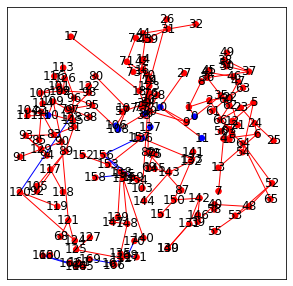

In [5]:
#whether to trim some obsolete branches
trim=1

if mode == 'train':
    Gs = generateSimG(snakelist, ves_snakelist, landmarks, ASSIGNNODE=1, ASSIGNEDGE=1, ASSIGNDIR=1)
elif mode == 'test':
    Gs = generateSimG(snakelist, ves_snakelist, landmarks, ASSIGNNODE=0, ASSIGNEDGE=0, ASSIGNDIR=1)
    
if trim:
    S = []
    for c in nx.connected_components(Gs):
        Gsi = Gs.subgraph(c).copy()
        gsidist = np.sum([Gs.edges[nodei]['dist'] for nodei in Gsi.edges()])
        # print(len(c),gsidist)
        if gsidist > 100 and len(Gsi.nodes()) > 5:
            S.append(Gsi)
    # sort based on length
    SSort = []
    for i in np.argsort([len(c) for c in S])[::-1]:
        SSort.append(S[i])
    if len(SSort)==0:
        G = Gs
    else:
        G = refreshid(nx.compose_all(SSort))
else:
    G = Gs
    
VESCOLORS = ['b'] + ['r'] * VESTYPENUM
NODECOLORS = ['r'] + ['b'] * BOITYPENUM
posz = {k: [-v['pos'].pos[0],-v['pos'].pos[1]] for k, v in G.nodes.items()}
if mode == 'train':
    edgecolors = [VESCOLORS[np.argmax(G.edges[v]['vestype'])] for v in G.edges()]
    nodecolors = [NODECOLORS[G.nodes[n]['boitype']] for n in G.nodes()]
else:
    edgecolors = [VESCOLORS[0] for v in G.edges()]
    nodecolors = [NODECOLORS[0] for n in G.nodes()]
plt.figure(figsize=(5,5))
nx.draw_networkx(G, pos=posz, node_size=30, node_color=nodecolors, edge_color=edgecolors)
plt.show()

for nodei in G.nodes():
    G.nodes[nodei]['pos'] = G.nodes[nodei]['pos'].pos
    G.nodes[nodei]['deg'] = G.degree[nodei]
    if mode == 'train':
        #remove extend types for distal branches, only applicable to iCafe
        if G.nodes[nodei]['boitype'] > 22:
            G.nodes[nodei]['boitype'] = 0
    elif mode == 'test':
        G.nodes[nodei]['boitype'] = 0
if mode == 'train':
    for edgei in G.edges():
        if G.edges[edgei]['vestype'][12] > 0:
            #print('merge m23')
            G.edges[edgei]['vestype'][5] += G.edges[edgei]['vestype'][12]
            G.edges[edgei]['vestype'][12] = 0
        if G.edges[edgei]['vestype'][13] > 0:
            G.edges[edgei]['vestype'][6] += G.edges[edgei]['vestype'][13]
            G.edges[edgei]['vestype'][13] = 0
elif mode == 'test':
    for edgei in G.edges():
        G.edges[edgei]['vestype'] = 0


## Save graph

In [6]:
graphtype='graphsim'
pickle_graph_name = path + '/' + graphtype + '_TH_' + pi + '.pickle'
nx.write_gpickle(G, pickle_graph_name)
print('Graph saved', pickle_graph_name, 'Node', len(G.nodes), 'Edges', len(G.edges))


Graph saved //DESKTOP2/iCafe/result//NVIFull/76_NVIVOL1_M/graphsim_TH_76_NVIVOL1_M.pickle Node 172 Edges 167
